# The Brisbane Weather Data

Import library

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
import math

# Recorded Weather Condition for Brisbane

In [2]:
bris_data = pd.read_csv('/course/data/a2/weather/weather_brisbane.csv')
bris_data.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-02-1,22.5,29.7,1.4,NaN,11.8,E,31.0,13:46,25.8,...,5,E,9,1013.7,28.5,50.0,3,E,15,1010.3
1,2021-02-2,21.4,25.7,19.8,NaN,0.0,W,20.0,09:07,21.7,...,8,W,11,1009.3,23.1,88.0,8,NE,2,1007.6
2,2021-02-3,20.4,29.1,44.6,NaN,8.6,ESE,33.0,12:14,25.5,...,7,ESE,13,1011.1,27.9,47.0,7,ESE,15,1009.9
3,2021-02-4,19.7,30.0,0.2,NaN,12.3,E,24.0,14:38,26.9,...,2,SE,7,1012.6,28.8,51.0,1,E,13,1010.1
4,2021-02-5,21.0,29.7,0.2,NaN,9.2,NE,24.0,13:40,26.6,...,5,ESE,7,1012.1,28.3,57.0,7,ENE,11,1009.0


In [3]:
bris_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               424 non-null    object 
 1   Minimum temperature (°C)           420 non-null    float64
 2   Maximum temperature (°C)           421 non-null    float64
 3   Rainfall (mm)                      405 non-null    float64
 4   Evaporation (mm)                   1 non-null      float64
 5   Sunshine (hours)                   373 non-null    float64
 6   Direction of maximum wind gust     413 non-null    object 
 7   Speed of maximum wind gust (km/h)  413 non-null    float64
 8   Time of maximum wind gust          413 non-null    object 
 9   9am Temperature (°C)               423 non-null    float64
 10  9am relative humidity (%)          423 non-null    float64
 11  9am cloud amount (oktas)           424 non-null    int64  

Summary:
- The 'Evaporation' Column has almost all values as 'Null'.

# The Demand For Queensland 

In [4]:
demand = pd.read_csv('/course/data/a2/weather/price_demand_data.csv')
qld_demand = demand[demand['REGION'] == 'QLD1']
qld_demand.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
1344,QLD1,2021/02/01 00:30:00,5981.46,False
1345,QLD1,2021/02/01 01:00:00,5892.93,False
1346,QLD1,2021/02/01 01:30:00,5770.95,False
1347,QLD1,2021/02/01 02:00:00,5740.73,False
1348,QLD1,2021/02/01 02:30:00,5657.71,False


Summary:
- The demand for QUEENSLAND does not contain the null cells and the does not have data missing. 
However, all values for 'price surge' column are false. 


## Pre-processing the Queensland Demand  

In [5]:
#Make the qld_demand have the date cell using regex

date_pattern = r'(\d{4}\/\d{2}\/\d{1,2})'

#apply it to the demand dataframe
qld_demand['Date'] = qld_demand['SETTLEMENTDATE'].str.extract(date_pattern)
qld_demand['Date'] = pd.to_datetime(qld_demand['Date'])

#create the diff_time columns to make the difference in time between two record of energy demand
qld_demand["diff_time"] = pd.to_datetime(qld_demand['SETTLEMENTDATE']).diff(periods = 1).dt.total_seconds()
#replace the first cell in diff time to 1800 seconds
qld_demand["diff_time"] = qld_demand["diff_time"].replace(np.nan, 1800)

#we calculate the consumption and change it to MWH:
qld_demand['CONSUMPTION'] = qld_demand['TOTALDEMAND']*qld_demand["diff_time"]
qld_demand['CONSUMPTION'] = qld_demand['CONSUMPTION']*(1e6)*(2.7777e-10)


qld_demand.head()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\3472723595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_demand['Date'] = qld_demand['SETTLEMENTDATE'].str.extract(date_pattern)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\3472723595.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_demand['Date'] = pd.to_datetime(qld_demand['Date'])
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\3472723595.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE,Date,diff_time,CONSUMPTION
1344,QLD1,2021/02/01 00:30:00,5981.46,False,2021-02-01,1800.0,2990.646260
1345,QLD1,2021/02/01 01:00:00,5892.93,False,2021-02-01,1800.0,2946.382499
1346,QLD1,2021/02/01 01:30:00,5770.95,False,2021-02-01,1800.0,2885.394207
1347,QLD1,2021/02/01 02:00:00,5740.73,False,2021-02-01,1800.0,2870.284630
1348,QLD1,2021/02/01 02:30:00,5657.71,False,2021-02-01,1800.0,2828.775792


## Plot the daily Consumption

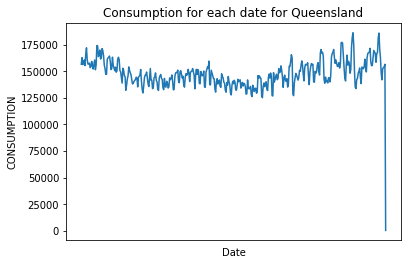

In [6]:
#plot the average demand for each date for qld
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

qld_date_demand = qld_demand.groupby('Date').sum()
qld_date_demand = qld_date_demand.reset_index()

#plot the bar plot
ax.plot([str(x) for x in qld_date_demand.index], qld_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date for Queensland')
plt.xticks([])
plt.show()
plt.close()

There is an outliner which is the last date in the demand which did not record the whole date. Therefore, we replace that with the mean value of the consumption.

In [7]:
qld_date_demand['CONSUMPTION'][qld_date_demand['CONSUMPTION'].idxmin()] = qld_date_demand.mean()["CONSUMPTION"]

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\3454812672.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  qld_date_demand['CONSUMPTION'][qld_date_demand['CONSUMPTION'].idxmin()] = qld_date_demand.mean()["CONSUMPTION"]
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\3454812672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_date_demand['CONSUMPTION'][qld_date_demand['CONSUMPTION'].idxmin()] = qld_date_demand.mean()["CONSUMPTION"]


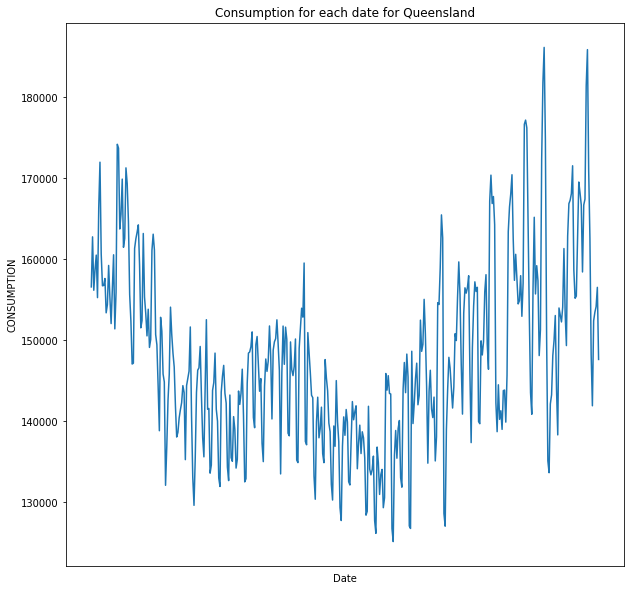

In [8]:
#plot the average demand for each date for qld
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

#plot the bar plot
ax.plot([str(x) for x in qld_date_demand.index], qld_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date for Queensland')
plt.xticks([])
plt.show()
plt.close()

# Merge the Brisbane weather dataset and the QLD demand dataset and pre-processing the merged_data

## Performing mergeing and pre_processing

In [9]:
#this function will change the direction in to 1-16 (numeric the direction)
def numeric_wind_direction(name_col, weather_data):
    weather_data[name_col] = OrdinalEncoder().fit_transform(weather_data[[name_col]])

- Because the demand for QLD per day has less row than the weather data for the Brisbane, we merge the weather data to the demand data.


In [10]:
#change the type of Date columns into datetime before mergeing
bris_data['Date'] = pd.to_datetime(bris_data['Date'])

#merge the demand to the weather dataset
original_merged_data = pd.merge(bris_data, qld_date_demand, how='left')



#numric the direction of the wind
numeric_wind_direction('Direction of maximum wind gust ',original_merged_data)
numeric_wind_direction('9am wind direction',original_merged_data)
numeric_wind_direction('3pm wind direction',original_merged_data)

#convert the time in maximum wind gust to the total seconds
original_merged_data['Time of maximum wind gust'] = '00:' + original_merged_data['Time of maximum wind gust']
original_merged_data['Time of maximum wind gust'] = pd.to_timedelta(original_merged_data['Time of maximum wind gust']).dt.total_seconds()

#change the Calm value in the dataframe to np.nan
original_merged_data = original_merged_data.replace([np.nan, np.inf, -np.inf, 'Calm'], np.nan)

#because as we obsevered the Dtype of wind speed is an object
#so we change it into float64 which will be identical for fillna working
original_merged_data['9am wind speed (km/h)'] = original_merged_data['9am wind speed (km/h)'].astype(np.float64)
original_merged_data['3pm wind speed (km/h)'] = original_merged_data['3pm wind speed (km/h)'].astype(np.float64)

#fill the nan value in the wind direction by the mode value 
#rather than the mean value in those weather condition
original_merged_data['9am wind direction'] = original_merged_data['9am wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['3pm wind direction'] = original_merged_data['3pm wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['Direction of maximum wind gust '] = original_merged_data['Direction of maximum wind gust '].fillna(original_merged_data['Direction of maximum wind gust '].mode())

#fill the nan value with the mean value for the rest of the weather condition
original_merged_data = original_merged_data.fillna(original_merged_data.mean())

# we reset the index
original_merged_data = original_merged_data.reset_index()
original_merged_data = original_merged_data.drop(['index'], axis=1)

original_merged_data.head()


C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\1851332101.py:33: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  original_merged_data = original_merged_data.fillna(original_merged_data.mean())


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND,PRICESURGE,diff_time,CONSUMPTION
0,2021-02-01,22.5,29.7,1.4,0.0,11.8,0.0,31.0,826.0,25.8,...,28.5,50.0,3,1.0,15.0,1010.3,313160.23,0.0,84600.0,156575.730757
1,2021-02-02,21.4,25.7,19.8,0.0,0.0,13.0,20.0,547.0,21.7,...,23.1,88.0,8,5.0,2.0,1007.6,325514.92,0.0,86400.0,162752.902791
2,2021-02-03,20.4,29.1,44.6,0.0,8.6,2.0,33.0,734.0,25.5,...,27.9,47.0,7,3.0,15.0,1009.9,312333.63,0.0,86400.0,156162.442329
3,2021-02-04,19.7,30.0,0.2,0.0,12.3,0.0,24.0,878.0,26.9,...,28.8,51.0,1,1.0,13.0,1010.1,317427.97,0.0,86400.0,158709.541008
4,2021-02-05,21.0,29.7,0.2,0.0,9.2,4.0,24.0,820.0,26.6,...,28.3,57.0,7,2.0,11.0,1009.0,321006.64,0.0,86400.0,160498.825907


## Drop the weather condition at a particular time to get consumption varaibles by itself

In [11]:
drop_feature = []

for col in original_merged_data:
    if "9am" in col or "3pm" in col:
        drop_feature.append(col)
        
consumption_merged_data = original_merged_data.drop(columns = drop_feature, axis = 1)

#we also need to drop out the other unrelated feature
consumption_merged_data = consumption_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time', 'Date'], axis=1)

consumption_merged_data.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
0,22.5,29.7,1.4,0.0,11.8,0.0,31.0,826.0,156575.730757
1,21.4,25.7,19.8,0.0,0.0,13.0,20.0,547.0,162752.902791
2,20.4,29.1,44.6,0.0,8.6,2.0,33.0,734.0,156162.442329
3,19.7,30.0,0.2,0.0,12.3,0.0,24.0,878.0,158709.541008
4,21.0,29.7,0.2,0.0,9.2,4.0,24.0,820.0,160498.825907


# Plot the Pearson correlation between each attribute in the merged dataframe 

In [12]:
corr = consumption_merged_data.corr()
corr.style.background_gradient(cmap='coolwarm')

D:\UniStudy\NAIE\venv\lib\site-packages\pandas\io\formats\style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
D:\UniStudy\NAIE\venv\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.722420,0.170463,nan,-0.233771,-0.332653,0.168125,0.156435,0.641388
Maximum temperature (°C),0.722420,1.000000,-0.031340,nan,0.273498,-0.248470,0.021876,0.218322,0.447150
Rainfall (mm),0.170463,-0.031340,1.000000,nan,-0.333221,-0.029699,0.096512,-0.102971,0.170120
Evaporation (mm),nan,nan,nan,nan,nan,nan,nan,nan,nan
Sunshine (hours),-0.233771,0.273498,-0.333221,nan,1.000000,0.010974,0.001780,0.053164,-0.260813
Direction of maximum wind gust,-0.332653,-0.248470,-0.029699,nan,0.010974,1.000000,0.176559,-0.247770,-0.167675
Speed of maximum wind gust (km/h),0.168125,0.021876,0.096512,nan,0.001780,0.176559,1.000000,0.031673,0.022627
Time of maximum wind gust,0.156435,0.218322,-0.102971,nan,0.053164,-0.247770,0.031673,1.000000,0.096587
CONSUMPTION,0.641388,0.447150,0.170120,nan,-0.260813,-0.167675,0.022627,0.096587,1.000000


By observing the correlation between the CONSUMpTION and each weather condition, it turns out there is no correlation between the CONSUMPTION and the weather conditon by using Pearson Correlation.

The relation between the weather condition and consumption does not a linear relation so that the pearson method can not detect the relationship between them

## Observed the correlation in Normalized Mutual Information method


In [13]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

discrete_data = consumption_merged_data.copy()
for name in consumption_merged_data:
    
    discrete_data[name] = equal_width.fit_transform(consumption_merged_data[[name]])

corr = discrete_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')

D:\UniStudy\NAIE\venv\lib\site-packages\sklearn\preprocessing\_discretization.py:194: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.250337,0.065704,0.000000,0.179913,0.176763,0.148247,0.132732,0.252104
Maximum temperature (°C),0.250337,1.000000,0.077780,0.000000,0.177743,0.142400,0.132229,0.137030,0.196022
Rainfall (mm),0.065704,0.077780,1.000000,0.000000,0.099400,0.075609,0.074474,0.118467,0.079079
Evaporation (mm),0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sunshine (hours),0.179913,0.177743,0.099400,0.000000,1.000000,0.145138,0.141291,0.149046,0.175882
Direction of maximum wind gust,0.176763,0.142400,0.075609,0.000000,0.145138,1.000000,0.168302,0.179637,0.129149
Speed of maximum wind gust (km/h),0.148247,0.132229,0.074474,0.000000,0.141291,0.168302,1.000000,0.150340,0.128649
Time of maximum wind gust,0.132732,0.137030,0.118467,0.000000,0.149046,0.179637,0.150340,1.000000,0.131479
CONSUMPTION,0.252104,0.196022,0.079079,0.000000,0.175882,0.129149,0.128649,0.131479,1.000000


Top 3 variables 

* Min temperature (0.252)
* Max temperature (0.196)
* sunshine (0.176)

# Performing Mututal Information to obsevered the correlation

In [14]:

# set our alpha significance level
ALPHA = 0.05

# get our features and class label
features = discrete_data[[x for x in discrete_data]]
class_label = discrete_data['CONSUMPTION']



Picking the top 3 features that have highest Mutual Information

In [15]:
mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "Minimum temperature (°C)": 0.6881
MI value for feature "Maximum temperature (°C)": 0.5257
MI value for feature "Rainfall (mm)": 0.1283
MI value for feature "Evaporation (mm)": 0.0000
MI value for feature "Sunshine (hours)": 0.4748
MI value for feature "Direction of maximum wind gust ": 0.3322
MI value for feature "Speed of maximum wind gust (km/h)": 0.3310
MI value for feature "Time of maximum wind gust": 0.3298
MI value for feature "CONSUMPTION": 2.6648


In [16]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('Sunshine (hours)', 0.474826178054352),
 ('Maximum temperature (°C)', 0.5256723126256295),
 ('Minimum temperature (°C)', 0.6881442600851619),
 ('CONSUMPTION', 2.66479520598757)]

## Feature Selection

In [17]:
features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Sunshine (hours)', 'CONSUMPTION']
consumption_merged_data = consumption_merged_data[features]

## Scatter plot for the selected features

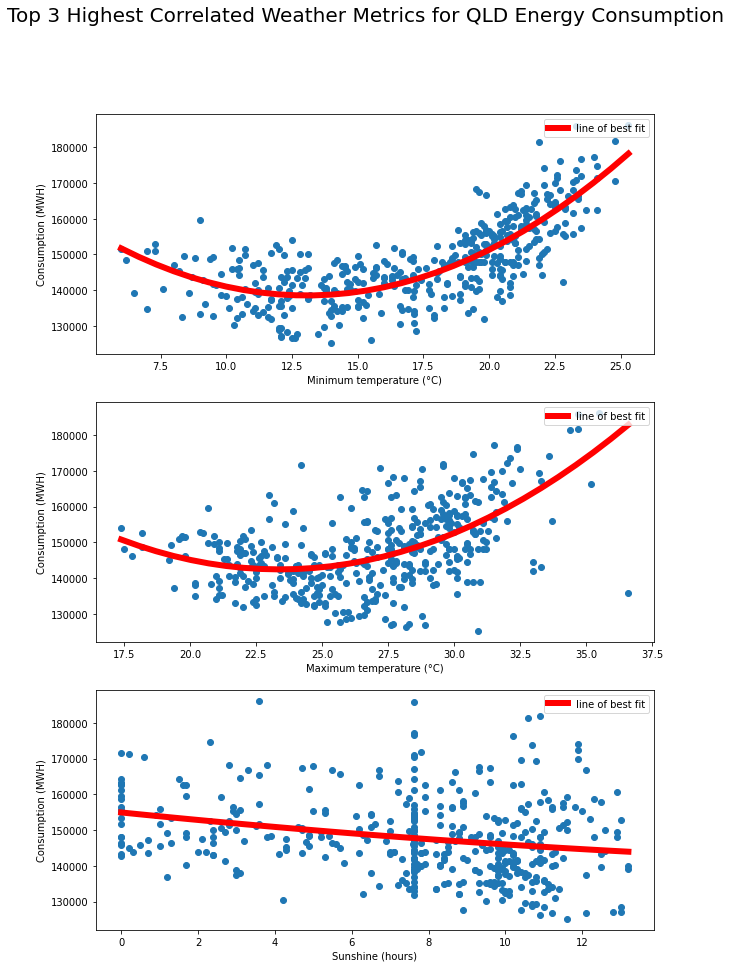

In [18]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,15)
fig, ax = plt.subplots(3)

for i in range (3):

    ax[i].scatter(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'])
    ax[i].set_xlabel(consumption_merged_data.columns[i])
    ax[i].set_ylabel("Consumption (MWH)")
    

    #draw line of best fit for actual value of y
    z = np.polyfit(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'], 2)
    curve_1 = np.array(z)
    x = np.linspace(min(consumption_merged_data.iloc[:,i]),max(consumption_merged_data.iloc[:,i]),30)
    y_1 = [np.polyval(curve_1, i) for i in x]
    ax[i].plot(x,y_1, 'r', linewidth = 6, label = "line of best fit")

    #adding lengend for the graph
    ax[i].legend(loc = "upper right")


plt.suptitle('Top 3 Highest Correlated Weather Metrics for QLD Energy Consumption',fontsize=20)

plt.savefig('qld_selected_plot.png')
plt.show()
plt.close()

# Apply supervised Machine Learning

## Keep the feature that we selected and split the data into training and testing

In [19]:
features  = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Sunshine (hours)']

X = consumption_merged_data[features]
Y = consumption_merged_data['CONSUMPTION']


Create the train and test data and initialize the cross validation

In [20]:
#split the data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=50)


## K-NN Regression 
## Also need to find a way to print the predict value and measure how good of an estimate it was fromt eh actual data 

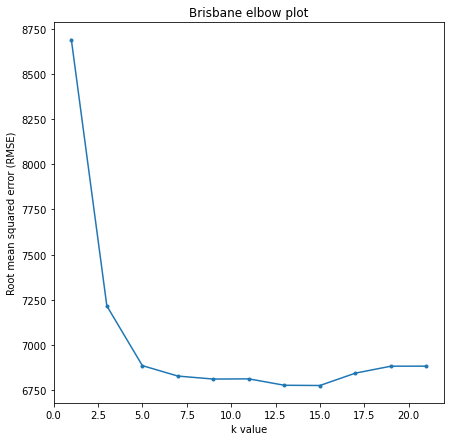

In [21]:
# Determine what the optimal number of nearest neighbours is using the elbow graph 

RMSE = []
for k in range(1,23,2):
    bris_knn_model = KNeighborsRegressor(n_neighbors=k)
    bris_knn_model.fit(X_train,Y_train)
    rmse = -cross_val_score(bris_knn_model, X_train, Y_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE.append(np.mean(rmse))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]
ax.plot(k,RMSE, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root mean squared error (RMSE)")
ax.set_title("Brisbane elbow plot")

plt.savefig("bris_elbow.png")
plt.show()
plt.close()


In [22]:
bris_knn_model = KNeighborsRegressor(n_neighbors=9)
bris_knn_model.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=9)

## Prediction

In [23]:
y_predict = bris_knn_model.predict(X_test)

In [24]:
print('r2: ' , metrics.r2_score(Y_test, y_predict))
RMSE = math.sqrt(metrics.mean_squared_error(Y_test, y_predict))
print("RMSE: ",  RMSE)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE/np.mean(Y_test))*100), "%")
MAE = metrics.mean_absolute_error(Y_test, y_predict)
print("MAE: ", MAE)
print("Percentage of error compare to average of actual value: ", round((MAE/np.mean(Y_test))*100), "%")

r2:  0.6316570697831477
RMSE:  6645.265576858185
Percentage of RMSE compare to average of actual value:  5 %
MAE:  5399.818430212994
Percentage of error compare to average of actual value:  4 %


Plot the Y train and Y predict and X variable on the same graph to see how well the curve is fitted to the data

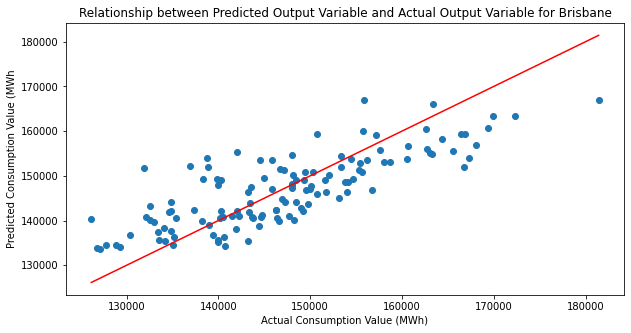

In [25]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_test, y_predict)

#plot the line y = x
x = np.linspace(min(Y_test), max(Y_test), 30)
ax.plot(x,x, 'r')


ax.set_xlabel("Actual Consumption Value (MWh)")
ax.set_ylabel("Predicted Consumption Value (MWh")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for Brisbane')

plt.savefig('Sample_bris_ytestvstrain.png')
plt.show()
plt.close()


## Observing how well the prediction compare to the actual value of the consumption

In [26]:
def observe_prediction(X_test, Y_test, y_predict, title, output_name):

    #create a subplot
    plt.rcParams["figure.figsize"] = (10,15)
    fig, ax = plt.subplots(3)


    for i in range (3):
        ax[i].scatter(X_test.iloc[:,i], Y_test, label = "Actual")
        ax[i].scatter(X_test.iloc[:,i], pd.Series(y_predict), label = "Predict")
        ax[i].set_xlabel(X_test.columns[i])
        ax[i].set_ylabel("Consumption")

        #adding lengend for the graph
        ax[i].legend(loc = "upper right")



    plt.suptitle(title,fontsize=20)

    plt.savefig(output_name)
    plt.show()
    plt.close()

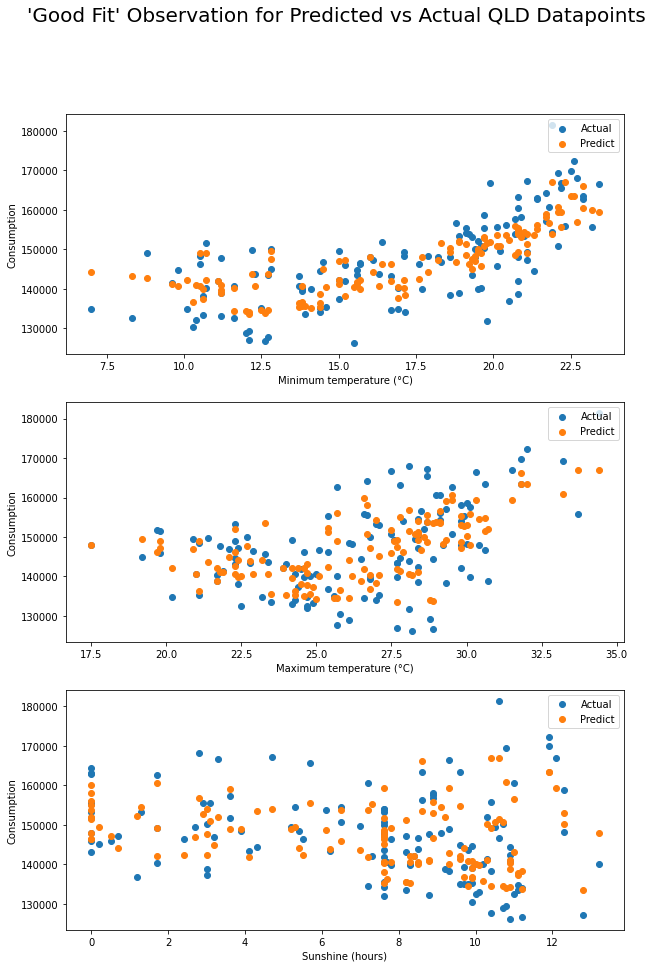

In [27]:
output_name = 'observing_predict_plot_bris.png'
title = "'Good Fit' Observation for Predicted vs Actual QLD Datapoints"
observe_prediction(X_test, Y_test, y_predict, title, output_name)

## Repeat this process for the time data to predict demand instead of consumption 

In [28]:
bris_data.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-02-01,22.5,29.7,1.4,NaN,11.8,E,31.0,13:46,25.8,...,5,E,9,1013.7,28.5,50.0,3,E,15,1010.3
1,2021-02-02,21.4,25.7,19.8,NaN,0.0,W,20.0,09:07,21.7,...,8,W,11,1009.3,23.1,88.0,8,NE,2,1007.6
2,2021-02-03,20.4,29.1,44.6,NaN,8.6,ESE,33.0,12:14,25.5,...,7,ESE,13,1011.1,27.9,47.0,7,ESE,15,1009.9
3,2021-02-04,19.7,30.0,0.2,NaN,12.3,E,24.0,14:38,26.9,...,2,SE,7,1012.6,28.8,51.0,1,E,13,1010.1
4,2021-02-05,21.0,29.7,0.2,NaN,9.2,NE,24.0,13:40,26.6,...,5,ESE,7,1012.1,28.3,57.0,7,ENE,11,1009.0


## Take out the energy demand at 9am and 3pm

In [29]:
time_pattern = r'(\d{2}:\d{2}:\d{2})'
qld_demand['Time'] = qld_demand['SETTLEMENTDATE'].str.extract(time_pattern)

qld_9am = qld_demand.loc[qld_demand['Time'] == "09:00:00"]
qld_9am= qld_9am.reset_index()
qld_9am = qld_9am.drop(['index'], axis = 1)
qld_3pm = qld_demand.loc[qld_demand['Time'] == "15:00:00"]
qld_3pm= qld_3pm.reset_index()
qld_3pm = qld_3pm.drop(['index'], axis = 1)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11664\737083899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_demand['Time'] = qld_demand['SETTLEMENTDATE'].str.extract(time_pattern)


In [30]:
original_merged_data = original_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time','CONSUMPTION'], axis =1)

## Finding the relationship with 9am

In [31]:
# drop columns rated to demand before merging point in time data 
qld_demand = qld_demand.drop(['PRICESURGE','TOTALDEMAND', 'diff_time','CONSUMPTION'], axis =1)

In [32]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_9am_data = pd.merge(original_merged_data, qld_9am, how='left')

#keeping 9am feature
feature_9am = []

for col in merged_9am_data:
    if '9am' in col:
        feature_9am.append(col)

#still keeping the totaldemand columns
feature_9am.append("TOTALDEMAND")
merged_9am_data = merged_9am_data[feature_9am]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_9am_data['TOTALDEMAND'] = merged_9am_data['TOTALDEMAND'].fillna(merged_9am_data['TOTALDEMAND'].mean())

merged_9am_data.head()

,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
0,25.8,61.0,5,1.0,9.0,1013.7,6617.98
1,21.7,94.0,8,14.0,11.0,1009.3,6832.43
2,25.5,65.0,7,3.0,13.0,1011.1,6363.61
3,26.9,58.0,2,10.0,7.0,1012.6,6028.88
4,26.6,63.0,5,3.0,7.0,1012.1,6376.57


## Finding NMI 9am

In [33]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_9am_data = merged_9am_data.copy()
for name in merged_9am_data:
    
    discrete_9am_data[name] = equal_width.fit_transform(merged_9am_data[[name]])

corr = discrete_9am_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
9am Temperature (°C),1.000000,0.167370,0.119827,0.167163,0.077432,0.211815,0.158701
9am relative humidity (%),0.167370,1.000000,0.155529,0.119898,0.100879,0.141826,0.157005
9am cloud amount (oktas),0.119827,0.155529,1.000000,0.109501,0.052293,0.088582,0.124437
9am wind direction,0.167163,0.119898,0.109501,1.000000,0.135774,0.152223,0.135396
9am wind speed (km/h),0.077432,0.100879,0.052293,0.135774,1.000000,0.090969,0.095664
9am MSL pressure (hPa),0.211815,0.141826,0.088582,0.152223,0.090969,1.000000,0.139945
TOTALDEMAND,0.158701,0.157005,0.124437,0.135396,0.095664,0.139945,1.000000


Highest correlated 9am feature
* 9 am temperature - 0.159

## Finding MI for feature selection

In [34]:
# get our features and class label
features = discrete_9am_data[[x for x in discrete_9am_data]]
class_label = discrete_9am_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "9am Temperature (°C)": 0.4296
MI value for feature "9am relative humidity (%)": 0.4129
MI value for feature "9am cloud amount (oktas)": 0.2871
MI value for feature "9am wind direction": 0.3529
MI value for feature "9am wind speed (km/h)": 0.2181
MI value for feature "9am MSL pressure (hPa)": 0.3770
MI value for feature "TOTALDEMAND": 2.6553


In [35]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('9am MSL pressure (hPa)', 0.37698479575433286),
 ('9am relative humidity (%)', 0.4128536651739426),
 ('9am Temperature (°C)', 0.4296214920710502),
 ('TOTALDEMAND', 2.6552907378902173)]

## KNN Regression 9am 

In [36]:
#keep the selected feature in the dataframe
features_9am  = ['9am MSL pressure (hPa)', '9am relative humidity (%)', '9am Temperature (°C)']

X_9am = merged_9am_data[features_9am]
Y_9am = merged_9am_data['TOTALDEMAND']

#split the data into test and train
X_9am_train, X_9am_test, Y_9am_train, Y_9am_test = train_test_split(X_9am,Y_9am, test_size=0.3, random_state=20)

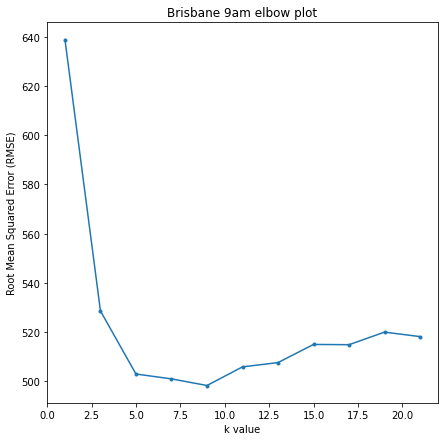

In [37]:
RMSE_9am = []
for k in range(1,23,2):
    bris_9am_knn_model = KNeighborsRegressor(n_neighbors=k)
    bris_9am_knn_model.fit(X_9am_train,Y_9am_train)
    rmse_9am = -cross_val_score(bris_9am_knn_model, X_9am_train, Y_9am_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_9am.append(np.mean(rmse_9am))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_9am, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Brisbane 9am elbow plot')

plt.show()
plt.close()

In [38]:
bris_9am_knn_model = KNeighborsRegressor(n_neighbors=9)
bris_9am_knn_model.fit(X_9am_train,Y_9am_train)

y_9am_predict = bris_9am_knn_model.predict(X_9am_test)
print('r2: ', metrics.r2_score(Y_9am_test, y_9am_predict))
RMSE_9am = math.sqrt(metrics.mean_squared_error(Y_9am_test, y_9am_predict))
print("RMSE: ",  RMSE_9am)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_9am/np.mean(Y_9am_test))*100), "%")
MAE_9am = metrics.mean_absolute_error(Y_9am_test, y_9am_predict)
print("MAE: ", MAE_9am)
print("Percentage of error compare to average of actual value: ", round((MAE_9am/np.mean(Y_9am_test))*100), "%")

r2:  0.3875820873703897
RMSE:  537.0772220499997
Percentage of RMSE compare to average of actual value:  9 %
MAE:  446.1570310594511
Percentage of error compare to average of actual value:  8 %


## Observing y actual vs y test graph for 9am data


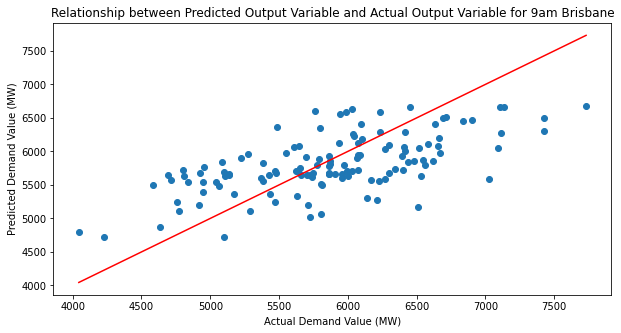

In [39]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_9am_test, y_9am_predict)

#plot the line y = x
x = np.linspace(min(Y_9am_test), max(Y_9am_test), 30)
ax.plot(x,x, 'r')

ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 9am Brisbane')


plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 9am weather condition 


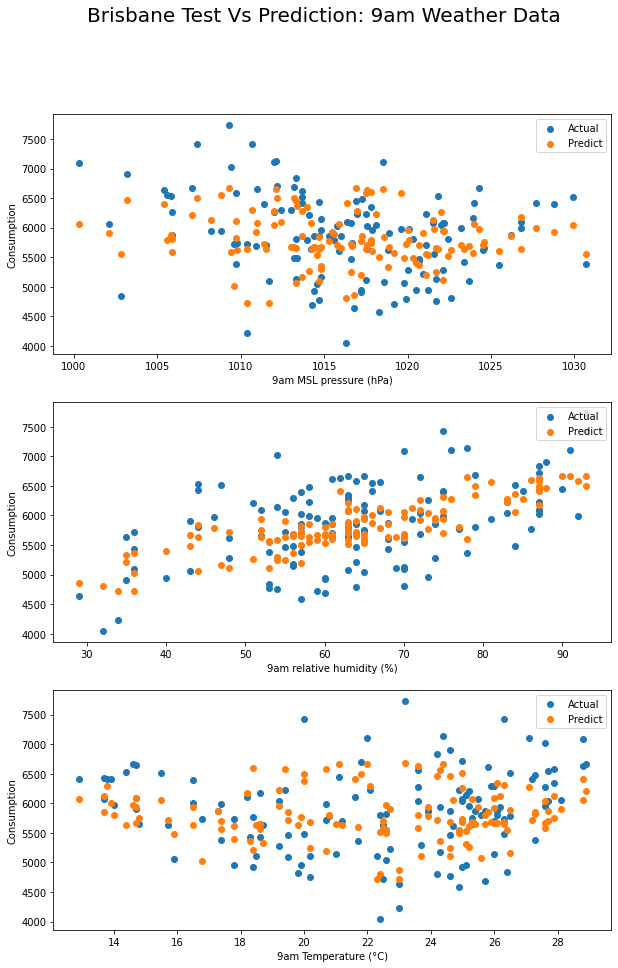

In [40]:
output_name = 'observing_predict_plot_9am_bris.png'
title = 'Brisbane Test Vs Prediction: 9am Weather Data'
observe_prediction(X_9am_test, Y_9am_test, y_9am_predict, title, output_name)

## Finding relationship with 3pm 

In [41]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_3pm_data = pd.merge(original_merged_data, qld_3pm, how='left')

#keeping 9am feature
feature_3pm = []

for col in merged_3pm_data:
    if '3pm' in col:
        feature_3pm.append(col)

#still keeping the totaldemand columns
feature_3pm.append("TOTALDEMAND")
merged_3pm_data = merged_3pm_data[feature_3pm]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_3pm_data['TOTALDEMAND'] = merged_3pm_data['TOTALDEMAND'].fillna(merged_3pm_data['TOTALDEMAND'].mean())

merged_3pm_data.head()

,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
0,28.5,50.0,3,1.0,15.0,1010.3,6761.34
1,23.1,88.0,8,5.0,2.0,1007.6,7107.34
2,27.9,47.0,7,3.0,15.0,1009.9,6542.09
3,28.8,51.0,1,1.0,13.0,1010.1,6747.40
4,28.3,57.0,7,2.0,11.0,1009.0,7010.48


## Finding NMI for 3pm 

In [42]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_3pm_data = merged_3pm_data.copy()
for name in merged_3pm_data:
    
    discrete_3pm_data[name] = equal_width.fit_transform(merged_3pm_data[[name]])

corr = discrete_3pm_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
3pm Temperature (°C),1.000000,0.150953,0.087891,0.142418,0.124456,0.207121,0.174753
3pm relative humidity (%),0.150953,1.000000,0.202108,0.195357,0.143747,0.149890,0.203693
3pm cloud amount (oktas),0.087891,0.202108,1.000000,0.090502,0.077003,0.075344,0.159850
3pm wind direction,0.142418,0.195357,0.090502,1.000000,0.161126,0.135986,0.131198
3pm wind speed (km/h),0.124456,0.143747,0.077003,0.161126,1.000000,0.109628,0.107963
3pm MSL pressure (hPa),0.207121,0.149890,0.075344,0.135986,0.109628,1.000000,0.169256
TOTALDEMAND,0.174753,0.203693,0.159850,0.131198,0.107963,0.169256,1.000000


- Highest correlation for 3pm weather was the 3pm relative humidity -- 0.204

# Feature selection 

In [43]:
# get our features and class label
features = discrete_3pm_data[[x for x in discrete_3pm_data]]
class_label = discrete_3pm_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "3pm Temperature (°C)": 0.4461
MI value for feature "3pm relative humidity (%)": 0.5192
MI value for feature "3pm cloud amount (oktas)": 0.3492
MI value for feature "3pm wind direction": 0.3221
MI value for feature "3pm wind speed (km/h)": 0.2501
MI value for feature "3pm MSL pressure (hPa)": 0.4390
MI value for feature "TOTALDEMAND": 2.4452


In [44]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('3pm MSL pressure (hPa)', 0.4390321325512479),
 ('3pm Temperature (°C)', 0.4460966137739567),
 ('3pm relative humidity (%)', 0.5192375447996274),
 ('TOTALDEMAND', 2.445226134449937)]

In [45]:
features_3pm  = ['3pm MSL pressure (hPa)', '3pm relative humidity (%)', '3pm Temperature (°C)']

X_3pm = merged_3pm_data[features_3pm]
Y_3pm = merged_3pm_data['TOTALDEMAND']

#split the data into test and train
X_3pm_train, X_3pm_test, Y_3pm_train, Y_3pm_test = train_test_split(X_3pm,Y_3pm, test_size=0.3, random_state=21)

### Apply KNN regressor for 3pm

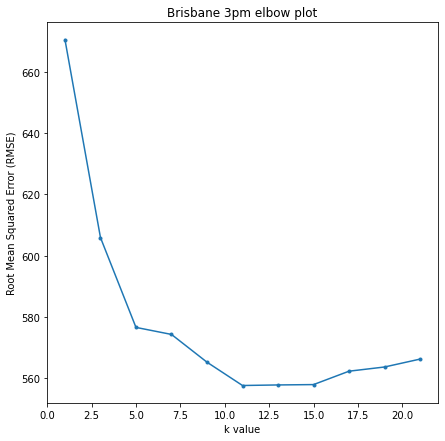

In [46]:
RMSE_3pm = []
for k in range(1,23,2):
    bris_3pm_knn_model = KNeighborsRegressor(n_neighbors=k)
    bris_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)
    rmse_3pm = -cross_val_score(bris_3pm_knn_model, X_3pm_train, Y_3pm_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_3pm.append(np.mean(rmse_3pm))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_3pm, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Brisbane 3pm elbow plot')

plt.show()
plt.close()

In [47]:
bris_3pm_knn_model = KNeighborsRegressor(n_neighbors=11)
bris_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)

y_3pm_predict = bris_3pm_knn_model.predict(X_3pm_test)
print('r2: ', metrics.r2_score(Y_3pm_test, y_3pm_predict))
RMSE_3pm = math.sqrt(metrics.mean_squared_error(Y_3pm_test, y_3pm_predict))
print("RMSE: ",  RMSE_3pm)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_3pm/np.mean(Y_3pm_test))*100), "%")
MAE_3pm = metrics.mean_absolute_error(Y_3pm_test, y_3pm_predict)
print("MAE: ", MAE_3pm)
print("Percentage of error compare to average of actual value: ", round((MAE_3pm/np.mean(Y_3pm_test))*100), "%")

r2:  0.5539675930031522
RMSE:  545.0347115591086
Percentage of RMSE compare to average of actual value:  9 %
MAE:  423.1505367585921
Percentage of error compare to average of actual value:  7 %


## Observing y actual vs y test graph for 3pm data


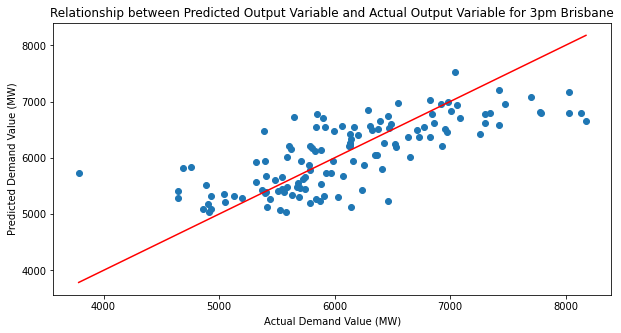

In [48]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_3pm_test, y_3pm_predict)

#plot the line y = x
x = np.linspace(min(Y_3pm_test), max(Y_3pm_test), 30)
ax.plot(x,x, 'r')

ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 3pm Brisbane')

plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 3pm weather condition 


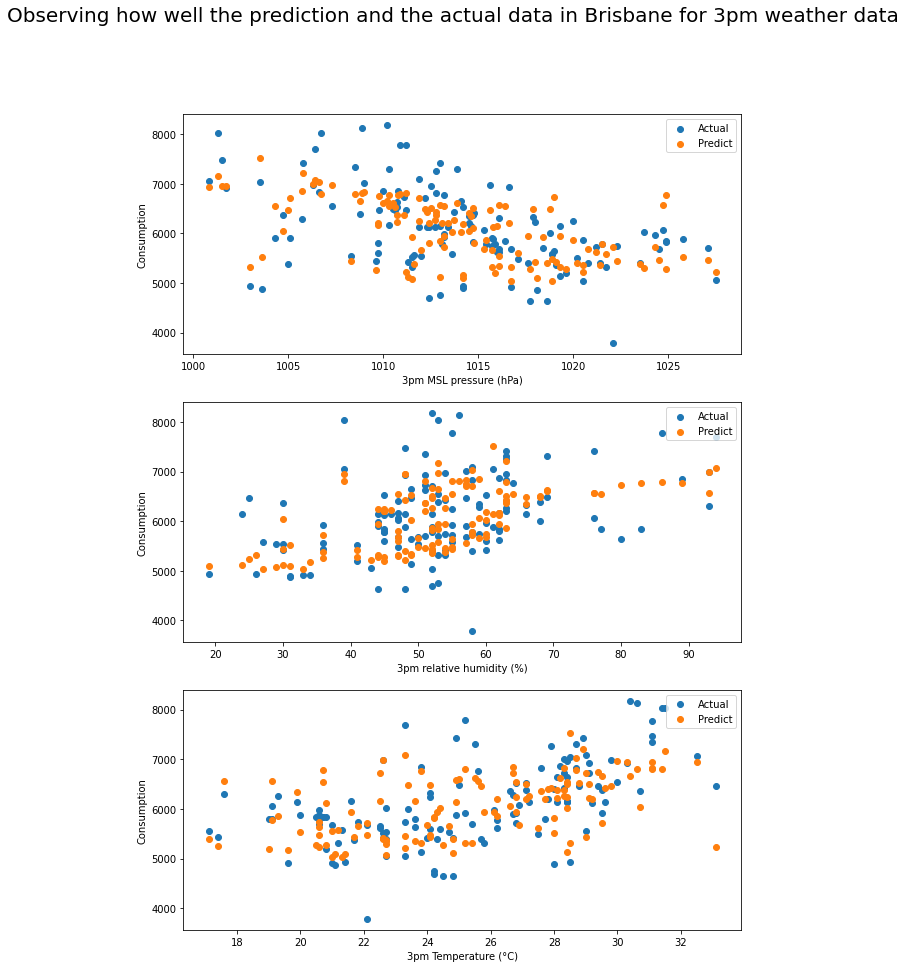

In [49]:
output_name = 'observing_predict_plot_3pm_bris.png'
title = 'Observing how well the prediction and the actual data in Brisbane for 3pm weather data'
observe_prediction(X_3pm_test, Y_3pm_test, y_3pm_predict, title, output_name)